<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Evaluation of Image-based salience maps using Incremental Deletion

This notebook demonstrates how to use the Incremental Deletion metric implemented under `metrics` on text. Incremental deletion computes the model scores of perturbed instances by deleting a configurable group of attributes for an instance. These attributes are removed until the entire instance is removed.  <br> The user can then retrieve the relevant scores per deletion and use these for visualization purposes or computing their own metrics.
<br> <br>
Several papers have implemented a metric like this one, a nice overview is given here: https://arxiv.org/pdf/2201.08164.pdf

#### Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
from metrics import Incremental_deletion
from pathlib import Path
# keras model and preprocessing tools
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K
from keras import utils
# dianna library for explanation
import dianna
from dianna import visualization
# for plotting
%matplotlib inline
from matplotlib import pyplot as plt

np.random.seed(0)

### 1 - Loading in the model and the data

We define a wrapper around ResNET in order to make it easily callable, we also provide some utilities in order to load an image example to work on

In [13]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)

    def run_on_batch(self, x):
        return self.model.predict(x, verbose=0)

model = Model()

In [14]:
def load_img(path):
    img = utils.load_img(path, target_size=model.input_size)
    x = utils.img_to_array(img)
    x = preprocess_input(x)
    return img, x

def to_img(x):
    z = np.copy(x)
    z = preprocess_input(z)
    img = utils.array_to_img(z)
    return img

Let's display what we will be working on.

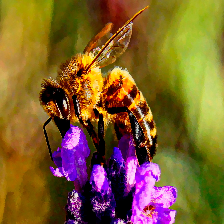

In [15]:
img, img_data = load_img(Path('..') / 'relevance_maps_properties' / 'metrics' / 'images' / 'bee.jpg')
img

### 2 - Explaining the Image using RISE

We leverage the RISE implementation from `dianna` in order to obtain a salience map for the example image. We will also display these salient scores in a visualization.

In [16]:
relevances = dianna.explain_image(model.run_on_batch, img_data, method="RISE",
                                labels=[309],
                                n_masks=1000, feature_res=6, p_keep=.1,
                                axis_labels={2: 'channels'})

Explaining: 100%|██████████| 10/10 [00:36<00:00,  3.70s/it]


Explanation for `bee`


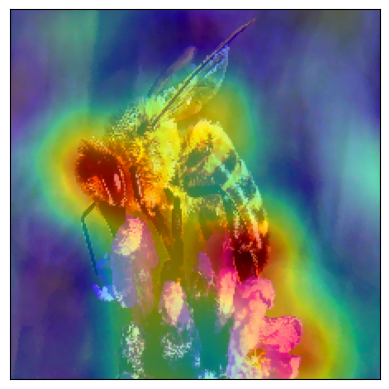

In [17]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

label = np.argmax(model.model.predict(img_data[None, ...], verbose=0))
salience_map = relevances[0]

print(f'Explanation for `{class_name(label)}`')
_ = visualization.plot_image(salience_map, utils.img_to_array(img) / 255., heatmap_cmap='jet', show_plot=False)


### 3 - Visualizing the effect of pixel removal

In order to get a visual idea of what's going on in Incremental deletion we provide a visual example in which we delete some fraction of pixels for the given image and show the effect on the model confidence. As we will see, removing pixels in the order of saliences given by RISE will yield in a significantly more drastic model score drop.

In [18]:
def generate_examples(img_data, salient_order, impute_value, step=5500, n_examples=5):
    '''Helper function to generate examples for removing pixels.
    '''
    n_removed = []
    scores = []
    imgs = []

    eval_img = np.copy(img_data)
    for k in range(n_examples):
        i, j = zip(*salient_order[k * step: (k + 1) * step])
        eval_img[i, j] = impute_value

        prediction = model.model.predict(eval_img[None, ...])
        print(f'{prediction.shape=}')
        score = np.max(prediction, axis=0)[label]
        scores.append(score)
        imgs.append(to_img(eval_img))
        n_removed.append((k + 1) * step)

    return imgs, scores, n_removed

In [19]:
salient_order = np.stack(np.unravel_index(np.argsort(salience_map, axis=None),
                                          salience_map.shape), axis=1)[::-1] # Get indices after sorting relevances
channel_mean = np.mean(img_data, axis=(0,1))

imgs, preds, nremoved = generate_examples(img_data, salient_order, channel_mean)

# Remove at random
np.random.shuffle(salient_order)
rand_imgs, rand_preds, nremoved = generate_examples(img_data, salient_order, channel_mean)


1/1 [==============================] - 0s 84ms/step
prediction.shape=(1, 1000)
1/1 [==============================] - 0s 85ms/step
prediction.shape=(1, 1000)
1/1 [==============================] - 0s 86ms/step
prediction.shape=(1, 1000)
1/1 [==============================] - 0s 84ms/step
prediction.shape=(1, 1000)
1/1 [==============================] - 0s 79ms/step
prediction.shape=(1, 1000)
1/1 [==============================] - 0s 78ms/step
prediction.shape=(1, 1000)
1/1 [==============================] - 0s 99ms/step
prediction.shape=(1, 1000)
1/1 [==============================] - 0s 83ms/step
prediction.shape=(1, 1000)
1/1 [==============================] - 0s 78ms/step
prediction.shape=(1, 1000)
1/1 [==============================] - 0s 75ms/step
prediction.shape=(1, 1000)


We visualize the effect of deleting pixels in order of RISE vs a random order below. The method of deletion was replacing pixels with the mean color in the image.

In [ ]:
# Visualize the examples
npixels = img_data.shape[0] * img_data.shape[1]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))

for i, (im, rand_img, removed) in enumerate(zip(imgs, rand_imgs, nremoved)):
    col = axes[:,i]

    for a in col:
        a.text(50, 240, 'Removed: {:.2f}'.format(removed / npixels), fontsize=13)
        a.axis('off')

    col[0].set_title("Confidence: {:.2f}".format(preds[i]))
    col[0].imshow(im)
    col[1].set_title("Confidence: {:.2f}".format(rand_preds[i]))
    col[1].imshow(rand_img)

fig.suptitle("Confidences for label 'bee' after removing pixels", size=20)
fig.tight_layout()
plt.savefig('Bee_arbitrary.pdf', dpi=200)

#### 4 - Evaluation and Visualization using Incremental Deletion
We now introduce our metric `Incremental_deletion` and call its visualize method to show the correctness of the explantion. Incremental deletion expects the model used for inference and `step` which defines the amount of pixels to delete per iteration.

In [ ]:
deleter = Incremental_deletion(model.model.predict, 224)

Evaluating: 100%|██████████| 22/22 [00:09<00:00,  2.26it/s]


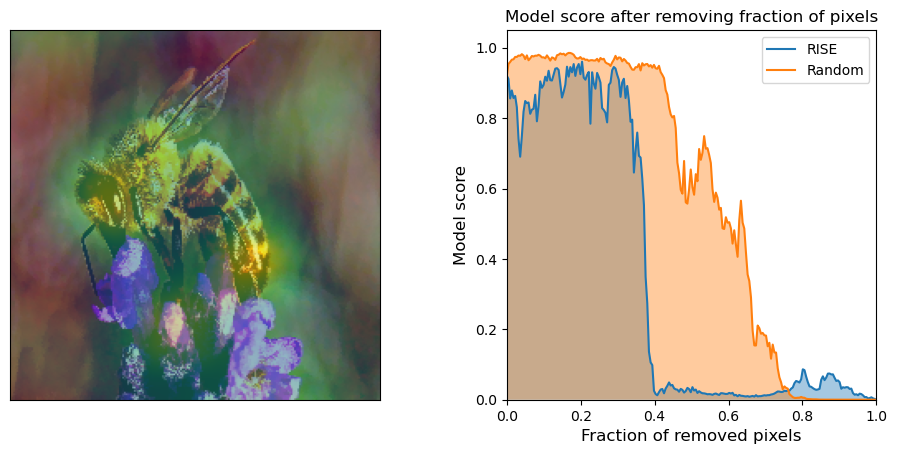

In [ ]:

results = deleter(img_data, salience_map[None,...], 10, verbose=0)
_ = deleter.visualize(salience_map,
                      utils.img_to_array(img) / 255.,
                      (np.array(results['salient_scores'][0]), np.array(results['random_scores'][0])),
                      ('RISE', 'Random'),
                      fontsize=12)

Given the scores, a typical approach is to compute the area under the deletion curves. We have extended this notion by computing the area between the salient deletion curve and the random baseline expressed as a flat value or fraction.

In [ ]:
auc = results['salient_auc']
abc = results['random_auc'] - auc
percentage_abc = (results['random_auc'] - auc) / results['random_auc']

print('RISE area under curve {:.3f}'.format(auc))
print('Area between curves: {:.3f}'.format(abc))
print('Fraction of RISE AUC compared to random AUC: {:.3f}'.format(percentage_abc))

TypeError: unsupported operand type(s) for -: 'list' and 'list'

### 5 - Conclusions

We have shown the intution and usage of the Incremental deletion metric. When viewing its performance against a random baseline, we can clearly see that RISE is able to reduce the accuracy of the model by perturbing in the order given by RISE. A next step would be to compare across different models.